In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score
import pandas as pd
import numpy as np

import sys
sys.path.append('../')

In [46]:
train_df = pd.read_csv("../data/processed/train.csv").drop(columns=["BOUT_ID", "EVENT_ID", "DATE", "BOUT_ORDINAL"])
test_df = pd.read_csv("../data/processed/test.csv").drop(columns=["BOUT_ID", "EVENT_ID", "DATE", "BOUT_ORDINAL"])

test_df = test_df.loc[test_df["RED_WIN"].notnull()]

In [47]:
X_train = train_df.drop(columns=["RED_WIN"])
y_train = train_df["RED_WIN"]
X_test = test_df.drop(columns=["RED_WIN"])
y_test = test_df["RED_WIN"]

In [48]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

pipe = Pipeline([
    ("scale", StandardScaler()),
    ("classify", LogisticRegression(max_iter=300, solver="liblinear", random_state=0))
])

param_grid = {
    "classify__C": np.logspace(-4, 4, 10),
    "classify__penalty": ["l1", "l2"],
}

grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring="neg_log_loss", n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END classify__C=9.999999999999999e-05, classify__penalty=l2; total time=   0.0s
[CV] END classify__C=9.999999999999999e-05, classify__penalty=l1; total time=   0.0s
[CV] END classify__C=0.000774263682681127, classify__penalty=l1; total time=   0.0s
[CV] END classify__C=0.000774263682681127, classify__penalty=l1; total time=   0.0s
[CV] END classify__C=0.000774263682681127, classify__penalty=l1; total time=   0.0s
[CV] END classify__C=9.999999999999999e-05, classify__penalty=l1; total time=   0.0s
[CV] END classify__C=9.999999999999999e-05, classify__penalty=l2; total time=   0.0s
[CV] END classify__C=9.999999999999999e-05, classify__penalty=l2; total time=   0.0s
[CV] END classify__C=9.999999999999999e-05, classify__penalty=l2; total time=   0.0s
[CV] END classify__C=0.000774263682681127, classify__penalty=l2; total time=   0.1s
[CV] END classify__C=9.999999999999999e-05, classify__penalty=l1; total time=   0.1s
[CV] EN

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('classify',
                                        LogisticRegression(max_iter=300,
                                                           random_state=0,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'classify__C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'classify__penalty': ['l1', 'l2']},
             scoring='neg_log_loss', verbose=2)

In [49]:
grid_search.best_params_

{'classify__C': 0.046415888336127774, 'classify__penalty': 'l1'}

In [50]:
y_pred_train = grid_search.predict_proba(X_train)[:, 1]
log_loss(y_train, y_pred_train)

0.632527244896285

In [51]:
y_pred_test = grid_search.predict_proba(X_test)[:, 1]
log_loss(y_test, y_pred_test)

0.6220705227757919

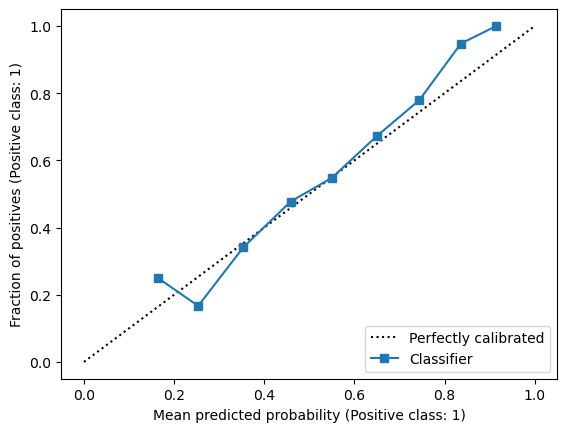

In [52]:
from sklearn.calibration import CalibrationDisplay

disp = CalibrationDisplay.from_predictions(y_test, y_pred_test, n_bins=10)